In [1]:
#-*- coding:utf-8 -*-
import os
import sys
import requests
import csv
import json

#키와 url 정의
key = "ttbsujoo851359001"
url = f"http://www.aladin.co.kr/ttb/api/ItemList.aspx?ttbkey=ttbsujoo851359001&QueryType=Bestseller&MaxResults=100" \
      "&start=1&SearchTarget=Book&output=js&Version=20131101&CategoryId=1"
  
#request 보내기
response = requests.get(url)
response_json = json.loads(response.text)  

#받은 response를 csv타입으로 바뀌주기
f = open('bookdata.csv','w',newline='')
writer=csv.writer(f)

writer.writerow(['ISBN13','TITLE','AUTHOR','PUBLISHER','PRICE','CATEGORY','RANK'])
for item in response_json['item']:
    writer.writerow([item['isbn13'],item['title'],item['author'],item['publisher'],
               item['priceStandard'],item['categoryName'],item['customerReviewRank']])
f.close()

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

filename='bookdata.csv'
df = pd.read_csv(filename)
isbn13_list = df['ISBN13']

# 결과값 저장, 2차원 리스트
values = list()

#크롤링1 - 100자평 크롤링
for idx1, isbn13 in enumerate(isbn13_list):     
    try:
        isbn13 = int(isbn13)
        print(isbn13)

        url1 = f'https://www.aladin.co.kr/shop/wproduct.aspx?ISBN={isbn13}'

        res = requests.get(url1)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "lxml")
        
        #item id 찾기
        item_id_url = soup.find('div', attrs={'class': 'tlist'}).ul.li.div.a['href']
        item_id = item_id_url[item_id_url.find('=') + 1:]


        url2 = f'https://www.aladin.co.kr/ucl/shop/product/ajax/GetCommunityListAjax.aspx?itemId={item_id}&IsAjax=true&pageType=1&sort=1&communitytype=CommentReview&IsOrderer=2&pageCount=500'

        res = requests.get(url2)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "lxml")

        np_40box_list_cont_list = soup.find_all("div", attrs={"class":"np_40box_list_cont"})

        for idx2, np_40box_list_cont in enumerate(np_40box_list_cont_list):

            for idx3, np_40box_list_cont_element in enumerate(np_40box_list_cont):
                if idx3 == 1:
                    src = np_40box_list_cont_element.img["src"]
                    rating = src[-5] if src[-5] != '0' else '10'
                elif idx3 == 3:
                    review = np_40box_list_cont_element.get_text().strip()
                    break
            values.append([isbn13, review])
            #print(review)

    except  Exception as e:
        print('#' * 20)
        print(url1)
        print(e)
        print('#' * 20)
        

9791167370280
9791191056556
9791165341909
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9791165341909
'NoneType' object has no attribute 'ul'
####################
9791167140050
9788954679947
9788954678407
9788926718803
9791191193138
9791130637617
9788932921037
9788937472060
9788932921044
9791197063275
9791166119651
9788932038674
9788956609959
9788937461033
9788954679930
9788970129815
9791190582438
9788956604992
9791136735638
9788936434267
9791196484194
9788970129822
9788925588735
9791159923340
9788936438456
9788936434496
9788937417566
9791190090018
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9791190090018
'NoneType' object has no attribute 'ul'
####################
9788972756194
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9788972756194
'NoneType' object has no attribute 'ul'
####################
9791196866792
9791191253313
9788936424589
9788936438418
9791134830557
9791185152431
9788954672214
9788983928207
97911

In [6]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ActionChains


#Chromedriver을 사용할 경우 상단에 뜨는 'chrome이 자동화된 테스트 소프트웨어에 의해 제어되고 있습니다' 제거
options = Options()
options.add_argument("headless")
options.add_argument('start-maximized')
options.add_argument('disable-infobars')
options.add_experimental_option("useAutomationExtension", False)
options.add_experimental_option("excludeSwitches",["enable-automation"])
driver = webdriver.Chrome(chrome_options=options, executable_path='C:/dev_python/Webdriver/chromedriver.exe')

for idx1, isbn13 in enumerate(isbn13_list):
    try:
        #time.sleep(10)
        isbn13 = int(isbn13)
        print(isbn13)
        driver.get(f'https://www.aladin.co.kr/shop/wproduct.aspx?ISBN={isbn13}')
        
        #알라딘의 마이리뷰 란은 스크롤을 거기까지 내려야 로딩이 됨
        driver.execute_script("window.scrollTo(0, 2000);")
        while (True):
            try:        
                driver.find_element_by_css_selector('#tabMyReviewTotal')
                driver.execute_script("window.scrollTo(0, window.scrollY + 2000);")
                break
            except:
                driver.execute_script("window.scrollTo(0, window.scrollY + 1000);")
                #time.sleep(3)   

        #마이리뷰의 전체 버튼을 누를때까지 스크롤
        #time.sleep(10)
        next_button=driver.find_element_by_css_selector('#tabMyReviewTotal')
        actions = ActionChains(driver) \
                .move_to_element(next_button) \
                .click()
        actions.perform()
        print('마이리뷰의 전체 버튼을 눌렀습니다')

        #스크롤을 내리면서 더보기 버튼 누르기
        while (True):
            try:        
                #time.sleep(10)
                next_button = driver.find_element_by_css_selector('#Ere_prod_allwrap > div.Ere_prod_blogwrap > div.Ere_prod_mblog_box.np_myreview > div.Ere_prod_mblog_box.np_myreview > div.Ere_prod_mblog_R > div.Ere_btn_more > a')
                print('found')
                actions = ActionChains(driver) \
                    .move_to_element(next_button) \
                    .click()
                actions.perform()  # actions 실행
                driver.execute_script("window.scrollTo(0, window.scrollY + 1500);")
            except:
                print('Not found')
                break
        print('마이리뷰에 있는 더보기 버튼을 모두 눌렀습니다')
        time.sleep(10)
        review_box=driver.find_elements_by_css_selector('#Ere_prod_allwrap > div.Ere_prod_blogwrap > div.Ere_prod_mblog_box.np_myreview > div.Ere_prod_mblog_box.np_myreview > div.Ere_prod_mblog_R > div.hundred_list')
        for review in review_box:
            review.find_element_by_css_selector( 'div.blog_list3 > ul > li:nth-child(1) > div >div')
            values.append([isbn13, review.text])
        driver.quit()
        
    except  Exception as e:
        print('#' * 20)
        print(url1)
        print(e)
        print('#' * 20)
        break
        
        
# csv 파일 쓰기
filename = filename.split('\\')
df = pd.DataFrame(values, columns=['ISBN13', 'review'])
df.to_csv(f'csv_reviews.csv',  encoding='utf-8-sig',index=False)

<ipython-input-6-e3914d192e52>:17: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options, executable_path='C:/dev_python/Webdriver/chromedriver.exe')


9791167370280
마이리뷰의 전체 버튼을 눌렀습니다
found
found
found
found
found
found
Not found
마이리뷰에 있는 더보기 버튼을 모두 눌렀습니다
9791191056556
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9791156758815
HTTPConnectionPool(host='127.0.0.1', port=62119): Max retries exceeded with url: /session/3b01e31601ccafb64bb98b765f6a449a/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019057A9B220>: Failed to establish a new connection: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다'))
####################


AttributeError: 'list' object has no attribute 'split'

In [7]:
filename = filename.split('\\')
df = pd.DataFrame(values, columns=['ISBN13', 'review'])
df.to_csv(f'csv_reviews.csv',  encoding='utf-8-sig',index=False)

AttributeError: 'list' object has no attribute 'split'

In [11]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data=df
train_data['review'] = train_data['review'].str.replace("[^가-힣1-9 ]","") #정규화
print(train_data)
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

             ISBN13                                             review
0     9791167370280           제목에 너무 큰 의미부여를 했나보다읽다보니 그냥 고유정사건이 생각났습니다
1     9791167370280  첫 장면부터 영상미가 엄청납니다 묘사가 집요하면 늘어지는 느낌이 들 수도 있는데 숙...
2     9791167370280   이 정도면 고유정한테 로열티 줘야지그냥 고유정 얘기지 이게 무슨작가의 말 민망하지 않나
3     9791167370280  은호 재인 지유 등 모든 등장인물에 몰입되어 그들의 입장을 들여다보고 공감하게된다 ...
4     9791167370280  어떻게 이렇게 자세하게 상세하게 글로 표현하는게 가능한건지 책을 읽고 있는게 아니라...
...             ...                                                ...
2133  9791167370280        완전한 행복이란이것만 없다면지금의 힘듬과 불행을 없앨수만 있다면나 역시도...
2134  9791167370280        마이리뷰 완전한 행복 프로그램에 출연한 작가를 보고 이미 읽은 7년의 밤...
2135  9791167370280        마이리뷰 완전한 행복예약구매로 양장본을 받아서 참 설레는 마음으로 읽어나...
2136  9791167370280        마이리뷰 완전한 행복몇 년 전 정유정 소설가의 강연에 참석한 적이 있었다...
2137  9791167370280        마이리뷰 완전한 행복책을 읽고나서 떠오른건 화차미야베미유키의 책 화차 말...

[2138 rows x 2 columns]
False


<ipython-input-11-1d7b626d15ca>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^가-힣1-9 ]","") #정규화


In [12]:
# 불용어 정의
file=open('bool.txt','r',encoding='UTF8')
stopwords=file.readlines()[0].split(' ')
file.close()

In [14]:
!pip install python-Levenshtein
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [25]:
from gensim.models import Word2Vec
model = Word2Vec(
    sentences = tokenized_data, 
    vector_size = 100, # 문자 벡터 차원 수
    window = 10, # 문자열 창 크기 : 중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지 결정
    min_count = 10, # 최소 문자 수
    workers = 4, # 병렬 처리 스레드 수
    sg = 1 #0은 CBOW, 1은 Skip-gram
    #CBOW는 주변에 있는 단어로 중간에 있는 단어를 예측
    #Skip-gram은 중심 단어에서 주변 단어를 예측
)

In [26]:
print(model.wv.index_to_key)

['읽다', '책', '작가', '소설', '좋다', '너무', '이야기', '기대', '다', '작품', '인간', '싶다', '재밌다', '유정', '정말', '글', '정', '들다', '자다', '력', '못', '나오다', '되어다', '재미있다', '내용', '영화', '문장', '대한', '그렇다', '어떻다', '밤', '많다', '느끼다', '마음', '가다', '모르다', '기다리다', '7년', '느낌', '묘사', '권', '고', '궁금하다', '요', '삶', '만들다', '보고', '주인공', '받다', '감정', '구매', '정유', '이렇다', '오다', '표현', '듯', '시선', '재미', '해주다', '몰입', '아쉽다', '추천', '읽히다', '끝', '새롭다', '시작', '기대하다', '역시', '처음', '악', '사랑', '이라', '좋아하다', '한국', '최고', '주다', '꼭', '전개', '인물', '많이', '버리다', '종', '쓰다', '무섭다', '엔', '사건', '놓다', '한번', '기원', '내내', '느껴지다', '에도', '흡입', '마지막', '계속', '독자', '1', '거', '기분', '서사', '처럼', '스토리', '손', '부분', '크다', '내다', '쓸다', '진짜', '이라는', '여성', '믿다', '넘다', '없이', '감', '이나', '세상', '문학', '이해', '긴장감', '인데', '가장', '신작', '해보다', '이란', '빠지다', '쉬다', '페이지', '그냥', '깊다', '모든', '제목', '인지', '오랜', '소재', '나다', '덮다', '결말', '차다', '힘', '먹다', '장', '이제', '사다', '보여주다', '돼다', '한편', '모습', '구성', '인가', '전작', '행복', '심리', '만에', '매력', '키르케', '28', '따뜻하다', '걸', '건', '빨리', '실망', '써다', '첫', '별', '

In [28]:
print(model.wv.most_similar(positive=['7년','밤']))

[('28', 0.9912179708480835), ('유정', 0.9811040163040161), ('정', 0.9748713970184326), ('작가', 0.9737715721130371), ('작품', 0.95115065574646), ('읽다', 0.9498017430305481), ('신작', 0.9497695565223694), ('좋아하다', 0.949689507484436), ('종', 0.9485232830047607), ('역시', 0.948258101940155)]


In [30]:
print(model.wv.most_similar(positive=['유정','행복']))

[('작품', 0.9922287464141846), ('작가', 0.9899231195449829), ('신작', 0.9897052049636841), ('28', 0.9896043539047241), ('역시', 0.9894447922706604), ('좋아하다', 0.9865953326225281), ('믿다', 0.9862160682678223), ('팬', 0.985745906829834), ('아직', 0.9848377704620361), ('신간', 0.9843892455101013)]


In [31]:
print(model.wv.most_similar(positive=['장르','스릴러']))

[('대단하다', 0.9977751970291138), ('긴장', 0.9976939558982849), ('생기다', 0.9976760745048523), ('장편', 0.997626781463623), ('무언가', 0.997601330280304), ('특히', 0.9975779056549072), ('문체', 0.9975236654281616), ('작다', 0.9974972009658813), ('함', 0.9974809288978577), ('여름', 0.9974650144577026)]


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


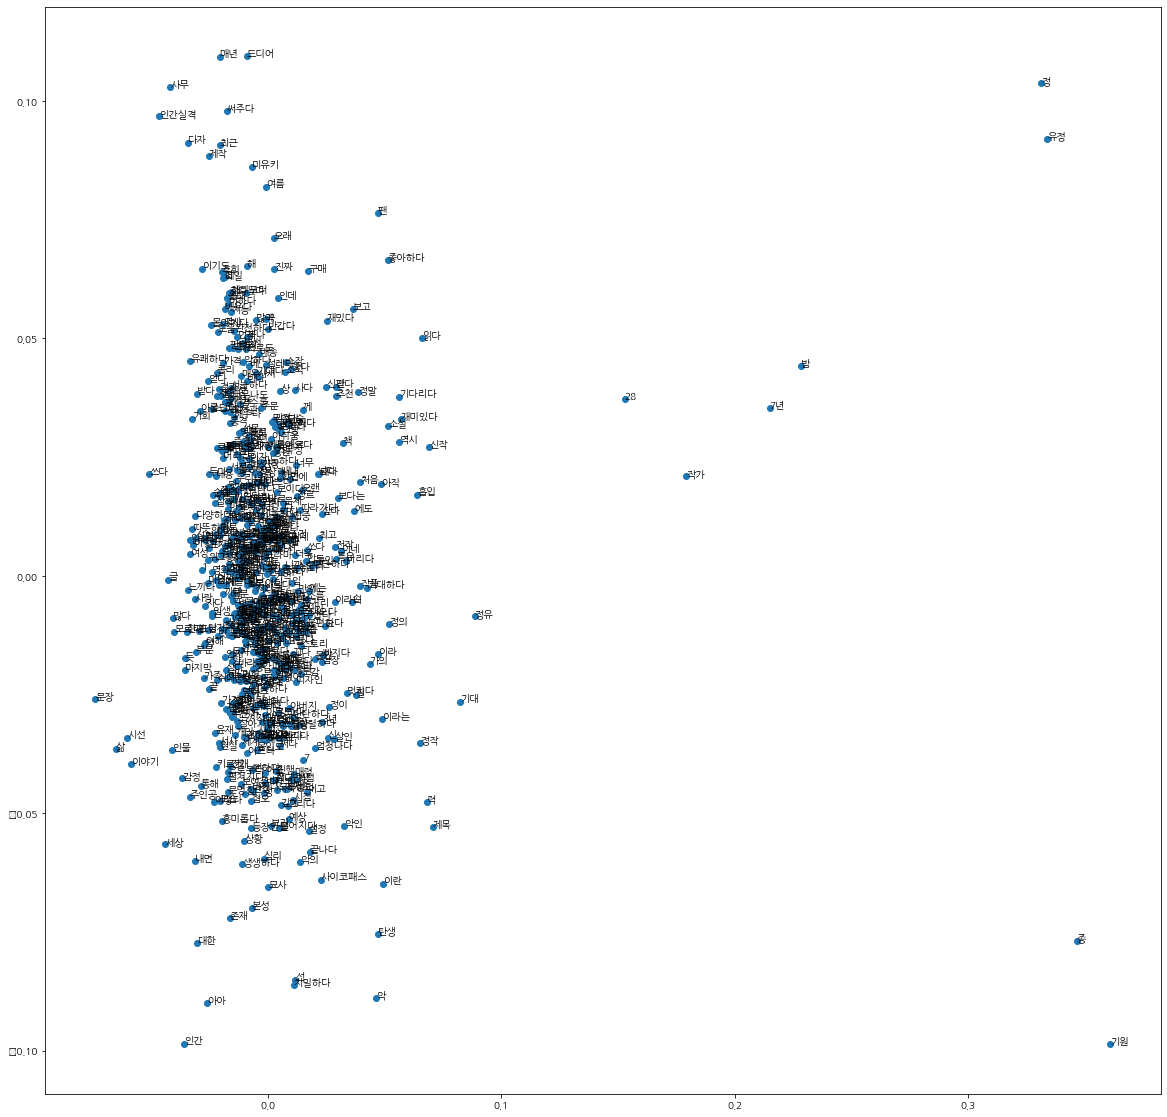

In [17]:
word_vectors = model.wv
vocabs =  list(model.wv.index_to_key)
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

rc('font',family="NanumGothic")

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)